In [3]:
import warnings
warnings.filterwarnings('ignore')
# For ignoring warnings printed by R magic commands

In [4]:
import os
import glob

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [6]:
# Load R magic
%load_ext rpy2.ipython
# Import ggplot2
%R require(ggplot2);

In [49]:
# If experiment parameters change, modify this function
def AddParametersAsColumns(df, file, protocol):
    expParams = file.split('/')[-1].split('__')
    df['numSubscribers'] = eval(expParams[1].split('_')[1])
    df['scheme'] = expParams[-1].split('.')[1]
    
    if protocol == 'radio':
        df['period (ms)'] = expParams[-1].split('.')[0].split('(')[1].split(')')[0]
    
# Turns all files of a given filname across a set of folders into a single dataframe
def DataSetAsDataFrame(files, headers, header=None, reset_index=True, protocol='dish'):
    # Read dataset as dataframe
    def ReadDataSet(file):
        if protocol == 'dish':
            df = pd.read_csv(file, sep='\s*', header=header, skiprows=4, na_filter=False, names=headers)
        else:
            df = pd.read_csv(file, sep=' ', header=header, na_filter=False, names=headers)
        AddParametersAsColumns(df, file, protocol)
        return df
    # Get the list of dataframes
    dfs = map(ReadDataSet, files)
    # Combine into a single dataframe
    df = pd.concat(dfs)
    if reset_index:
        df.reset_index(inplace=True)
        df.drop('index', axis=1, inplace=True)
    return df

In [8]:
%%R 
plotTheme <- theme(legend.title=element_blank(), legend.position="top", legend.text=element_text(size=6))

In [37]:
directory = '../../../../../results/apps/pub/vms/fanout/'
dish_data_time_folder = '20171217231930.266914/'
dish_files = glob.glob(directory + dish_data_time_folder + 'dish_stats_with__*')
radio_data_time_folder = '20170827074947.700696/'
radio_files = glob.glob(directory + radio_data_time_folder + 'radio_stats_with__*')

In [24]:
message_size = 51*8 # in bits

In [50]:
dish_df = DataSetAsDataFrame(dish_files, ['in (kbps)', 'out (kbps)'])

In [51]:
dish_df.head()

,in (kbps),out (kbps),numSubscribers,scheme
0,81630.94,0.0,8,baseerat
1,80950.90,0.0,8,baseerat
2,80190.05,0.0,8,baseerat
3,76888.28,0.0,8,baseerat
4,81164.18,0.0,8,baseerat


In [55]:
dish_df['in (mbps)'] = dish_df['in (kbps)'] / 1024
dish_df['in (krps)'] = dish_df['in (kbps)'] / message_size

In [56]:
dish_df.head()

,in (kbps),out (kbps),numSubscribers,scheme,in (mbps),in (krps)
0,81630.94,0.0,8,baseerat,79.717715,200.075833
1,80950.90,0.0,8,baseerat,79.053613,198.409069
2,80190.05,0.0,8,baseerat,78.310596,196.544240
3,76888.28,0.0,8,baseerat,75.086211,188.451667
4,81164.18,0.0,8,baseerat,79.261895,198.931814


In [57]:
dish_df['in (mbps)'].where(dish_df['scheme'] == 'baseerat').describe()

count    295.000000
mean      72.098332
std        5.161891
min       49.322832
25%       69.756191
50%       73.005781
75%       75.257607
max       80.961982
Name: in (mbps), dtype: float64

In [58]:
dish_df['in (krps)'].where(dish_df['scheme'] == 'baseerat').mean()

180.95267539049507

In [59]:
dish_df['in (mbps)'].where(dish_df['scheme'] == 'unicast').describe()

count    301.000000
mean      16.482798
std       24.689941
min        0.071904
25%        0.300430
50%        1.416279
75%       27.020654
max       80.961982
Name: in (mbps), dtype: float64

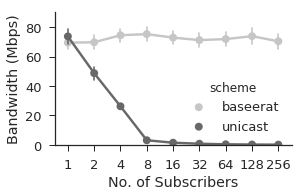

In [61]:
sns.set(style='ticks', font_scale=1.3, rc={"lines.linewidth": 0.9})
ax = sns.factorplot(x='numSubscribers', y='in (mbps)', hue='scheme', data=dish_df, palette="Greys",
                   size=3, kind="point", legend=True, legend_out=False, aspect=1.5, ci='sd', scale=1.5)
ax.set(xlabel='No. of Subscribers', ylabel='Bandwidth (Mbps)')
ax.set(ylim=(0, 90))
plt.savefig('zmq-bandwidth-mbps.jpg')
plt.show()

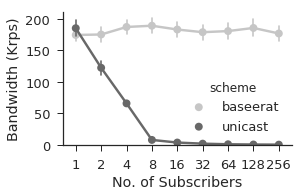

In [65]:
sns.set(style='ticks', font_scale=1.3, rc={"lines.linewidth": 0.9})
ax = sns.factorplot(x='numSubscribers', y='in (krps)', hue='scheme', data=dish_df, palette="Greys",
                   size=3, kind="point", legend=True, legend_out=False, aspect=1.5, ci='sd', scale=1.5)
ax.set(xlabel='No. of Subscribers', ylabel='Bandwidth (Krps)')
ax.set(ylim=(0, 210))
plt.savefig('zmq-bandwidth-krps.jpg')
plt.show()

In [70]:
dish_df[['scheme', 'numSubscribers', 'in (kbps)', 'in (mbps)', 'in (krps)']].to_csv(directory + 'dish_throughput_stats.csv', index=False)

In [52]:
radio_df = DataSetAsDataFrame(radio_files, ['%cpu', '%mem'], protocol='radio')

In [53]:
radio_df.head()

,%cpu,%mem,numSubscribers,scheme,period (ms)
0,18.3,0.1,32,unicast,1
1,19.0,0.1,32,unicast,1
2,19.3,0.1,32,unicast,1
3,19.0,0.1,32,unicast,1
4,18.3,0.1,32,unicast,1


In [67]:
radio_df['%cpu'].where(radio_df['scheme'] == 'baseerat').where(radio_df['numSubscribers'] == 1).describe()

count    10.000000
mean      4.970000
std       0.397352
min       4.300000
25%       4.700000
50%       5.000000
75%       5.225000
max       5.700000
Name: %cpu, dtype: float64

In [68]:
radio_df['%cpu'].where(radio_df['scheme'] == 'unicast').where(radio_df['numSubscribers'] == 64).describe()

count    10.000000
mean     32.050000
std       0.397911
min      31.600000
25%      31.600000
50%      32.300000
75%      32.300000
max      32.600000
Name: %cpu, dtype: float64

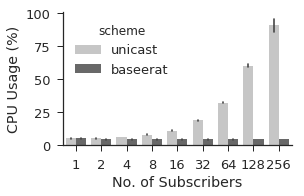

In [69]:
sns.set(style='ticks', font_scale=1.3, rc={"lines.linewidth": 0.9})
ax = sns.factorplot(x='numSubscribers', y='%cpu', hue='scheme', data=radio_df, palette="Greys",
                   size=3, kind="bar", legend=True, legend_out=False, aspect=1.5, ci='sd')
ax.set(xlabel='No. of Subscribers', ylabel='CPU Usage (%)')
plt.savefig('zmq-cpu-usage.jpg')
plt.show()

In [71]:
radio_df.to_csv(directory + 'radio_cpu_stats.csv', index=False)